In [26]:
import pandas as pd
import numpy as np

data = pd.read_csv("./resources/postcodes_labelled.csv")
data = data.drop_duplicates()

In [3]:
from geo import get_gps_lat_long_from_easting_northing, lat_long_to_xyz

def df_to_lat_long_zero_origin(df):
    # Check if required columns are present
    if 'easting' not in df.columns or 'northing' not in df.columns:
        raise ValueError("DataFrame must contain 'easting' and 'northing' columns")
    
    # Convert easting and northing to latitude and longitude
    df['latitude'], df['longitude'] = get_gps_lat_long_from_easting_northing(df['easting'], df['northing'])

    # Ensure no NaN values in latitude and longitude
    if df['latitude'].isnull().any() or df['longitude'].isnull().any():
        raise ValueError("Conversion to latitude and longitude resulted in NaN values")

    # Shift origin to zero
    df['latitude'] = df['latitude'] - df['latitude'].min()
    df['longitude'] = df['longitude'] - df['longitude'].min() 

    # Scale the data
    df['latitude_scaled'] = df['latitude'] / df['latitude'].max()
    df['longitude_scaled'] = df['longitude'] / df['longitude'].max() 

    # Drop intermediate latitude and longitude columns
    df.drop(['latitude', 'longitude'], axis=1, inplace=True)   

    return df

In [ ]:
y = data['historicallyFlooded']
data = df_to_lat_long_zero_origin(data).drop(['easting', 'northing', 'postcode', 'historicallyFlooded','riskLabel', 'medianPrice'], axis=1)

In [5]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns

missing = data.isnull().sum() / len(data)
features_to_drop = missing[missing > 0.3].index
data = data.drop(columns=features_to_drop)

# Updata after the column drop
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns

In [7]:
data

,soilType,elevation,distanceToWatercourse,localAuthority,latitude_scaled,longitude_scaled
0,Unsurveyed/Urban,20,1240.0,Bath and North East Somerset,0.775395,0.510832
1,Unsurveyed/Urban,20,1550.0,Bath and North East Somerset,0.775065,0.511392
2,Unsurveyed/Urban,20,1540.0,Bath and North East Somerset,0.774846,0.511346
3,Unsurveyed/Urban,30,1450.0,Bath and North East Somerset,0.777292,0.511284
4,Unsurveyed/Urban,30,1410.0,Bath and North East Somerset,0.777106,0.511213
...,...,...,...,...,...,...
79995,Unsurveyed/Urban,10,1790.0,Hounslow,0.836469,0.782931
79996,Unsurveyed/Urban,10,2020.0,Hounslow,0.837418,0.782727
79997,Unsurveyed/Urban,10,1940.0,Hounslow,0.837307,0.782974
79998,Planosols,100,1790.0,Hillingdon,0.899571,0.756581


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42) 

In [9]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='mean')
X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
X_test[num_features] = num_imputer.fit_transform(X_test[num_features])

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train[num_features])
X_test_scaled = ss.transform(X_test[num_features])

X_train_df_scaled = pd.DataFrame(X_train_scaled, columns=ss.get_feature_names_out(num_features), index=X_train.index)
X_test_df_scaled= pd.DataFrame(X_test_scaled, columns=ss.get_feature_names_out(num_features), index=X_test.index)

ohe = OneHotEncoder(sparse_output=False)
encoded_cat_train = ohe.fit_transform(X_train[cat_features])
encoded_cat_test = ohe.fit_transform(X_test[cat_features])

encoded_cat_df_train = pd.DataFrame(encoded_cat_train, columns=ohe.get_feature_names_out(cat_features), index=X_train.index)
encoded_cat_df_test= pd.DataFrame(encoded_cat_test, columns=ohe.get_feature_names_out(cat_features), index=X_test.index)

X_train = pd.concat([X_train_df_scaled, encoded_cat_df_train], axis=1)
X_test = pd.concat([X_test_df_scaled, encoded_cat_df_test], axis=1)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def logistic_regression(X_train, X_test, y_train, y_test, print_result=False, plot=False):

    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)

    precision= precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    f1_multi = f1_score(y_test, y_pred, average='binary')
    
    if print_result:
        print("lr Precision:", precision)
        print("lr Recall:", recall)
        print("lr Accuracy:", accuracy)
        print("lr F1-Score:", f1_multi)

    if plot:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    return precision, recall, accuracy

In [12]:
precisions = []
recalls = []
accuracies = []
np.random.seed(42)

# drop_percentage_range = [*range(10, 90, 5), *range(90, 100)]
drop_percentage_range = range(100)
negative_indices = y_train[y_train == 0].index
for dp in drop_percentage_range:
    
    # Drop most of the negative data points
    num_to_drop = int(len(negative_indices) * dp / 100)  
    rows_to_drop = np.random.choice(negative_indices, num_to_drop, replace=False)

    X_train_reduced = X_train.drop(rows_to_drop)
    y_train_reduced = y_train.drop(rows_to_drop)

    pre, rec, acc = logistic_regression(X_train_reduced, X_test, y_train_reduced, y_test)
    precisions.append(pre)
    recalls.append(rec)
    accuracies.append(acc)

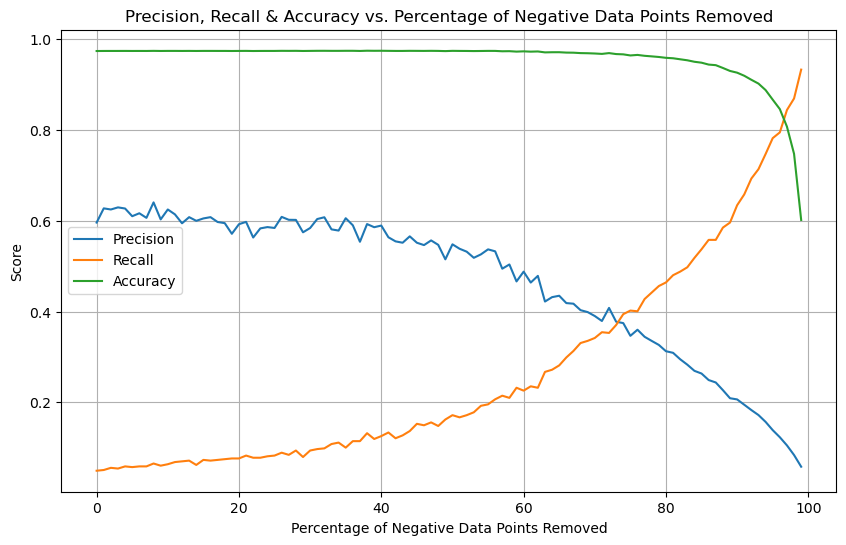

In [13]:
# Plot the precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(drop_percentage_range, precisions, label='Precision')
plt.plot(drop_percentage_range, recalls, label='Recall')
plt.plot(drop_percentage_range, accuracies, label='Accuracy')
plt.xlabel('Percentage of Negative Data Points Removed')
plt.ylabel('Score')
plt.title('Precision, Recall & Accuracy vs. Percentage of Negative Data Points Removed')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
SCORE_MATRIX = {
    "balanced": (750, 105, -3210, 10160),
    "recall_precision_focused": (74, 47, -397.5, 1486.33),
    "ones": (1, -1, -1, 1)
}

In [15]:
from sklearn.metrics import confusion_matrix, make_scorer

# Define balanced scoring function based on FN, FP, TN, TP with equal weights
def scoring_core(y_true, y_pred, mode):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Define weights for each component
    avg_tn, avg_fp, avg_fn, avg_tp = SCORE_MATRIX[mode]

    # total_weights = avg_tp + avg_fp + avg_fn + avg_tn

    # tp_weight = avg_tp / total_weights
    # fp_weight = avg_fp / total_weights
    # fn_weight = avg_fn / total_weights
    # tn_weight = avg_tn / total_weights

    # Calculate custom score
    # score = (tp_weight * tp) + (fp_weight * fp) + (fn_weight * fn) + (tn_weight * tn)
    score = ((avg_tp * tp) + (avg_fp * fp) + (avg_fn * fn) + (avg_tn * tn)) / len(y_true)
    return score

def custom_scorer(mode):
    return make_scorer(scoring_core, mode=mode)
# # Convert the function into a scorer
# balanced_scorer = make_scorer(balanced_score)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


results = []

np.random.seed(42)

param_distrib = [
    {'classifier__max_depth': randint(low=1, high=50),
     'classifier__n_estimators': randint(low=100, high=500),
    'classifier__min_samples_split': randint(low=2, high=10),
    'classifier__max_features': randint(low=1, high=8)}]

model_pipe = Pipeline([('classifier',RandomForestClassifier())])

drop_percentage_range = range(55, 100, 5)
negative_indices = y_train[y_train == 0].index

mode = "f1"
scoring = custom_scorer(mode) if mode in SCORE_MATRIX else mode

for dp in drop_percentage_range:    
    # Drop most of the negative data points
    num_to_drop = int(len(negative_indices) * dp / 100)  
    rows_to_drop = np.random.choice(negative_indices, num_to_drop, replace=False)

    X_train_reduced = X_train.drop(rows_to_drop)
    y_train_reduced = y_train.drop(rows_to_drop)


    rnd_search = RandomizedSearchCV(model_pipe, param_distributions=param_distrib, cv=5, n_iter=10,
                           scoring=scoring, n_jobs=-1, random_state=1)
    
    rnd_search.fit(X_train_reduced, y_train_reduced)
    rnd_model = rnd_search.best_estimator_
    

    y_test_pred = rnd_model.predict(X_test)
    
    
    results.append({
        'drop_percentage': dp,
        'best_models': rnd_model,
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'accuracy': accuracy_score(y_test, y_test_pred),
        'target_score': scoring_core(y_test, y_test_pred, mode) if mode in SCORE_MATRIX else None,
    })

    print(dp, "%")

55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %


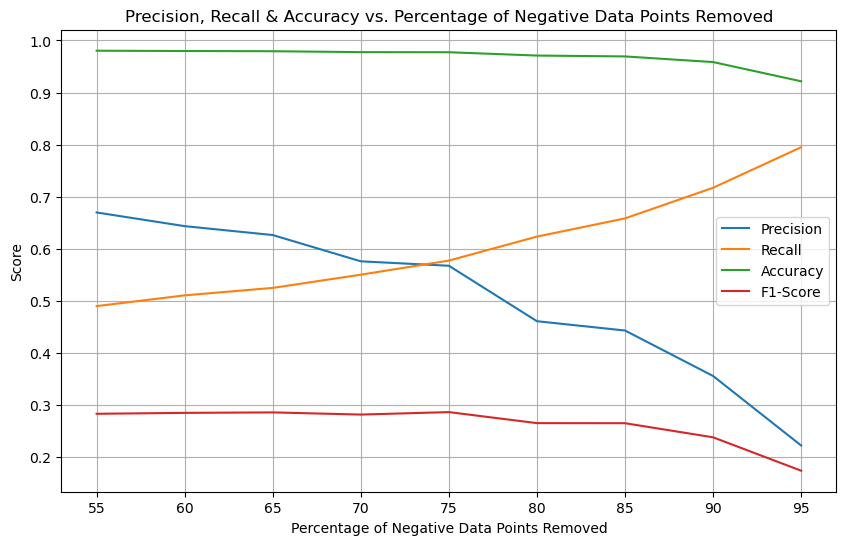

In [17]:
drop_percentage_range = [res['drop_percentage'] for res in results]
precisions = [res['precision'] for res in results]
recalls = [res['recall'] for res in results]
accuracies = [res['accuracy'] for res in results]
f1_s = [res['precision'] * res['recall'] / (res['precision'] + res['recall']) for res in results]

# Plot the precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(drop_percentage_range, precisions, label='Precision')
plt.plot(drop_percentage_range, recalls, label='Recall')
plt.plot(drop_percentage_range, accuracies, label='Accuracy')
plt.plot(drop_percentage_range, f1_s, label='F1-Score')
plt.xlabel('Percentage of Negative Data Points Removed')
plt.ylabel('Score')
plt.title('Precision, Recall & Accuracy vs. Percentage of Negative Data Points Removed')
plt.legend()
plt.grid(True)
plt.show()

Generate a separated graph if the user specified a special scoring method.

In [18]:
if mode in SCORE_MATRIX:    
    target_score = [res['target_score'] for res in results]

    # Plot the precision and recall curves
    plt.figure(figsize=(10, 6))
    plt.plot(drop_percentage_range, target_score, label='target__score')
    plt.xlabel('Percentage of Negative Data Points Removed')
    plt.ylabel('Score')
    plt.title('Target Score vs. Percentage of Negative Data Points Removed')
    plt.legend()
    plt.grid(True)
    plt.show()

It can be observed that the default threshold (prob >= 0.5) is the best point to achieve a balanced outcome of recall and precision. Thus threshold will not be further adjusted in this project.

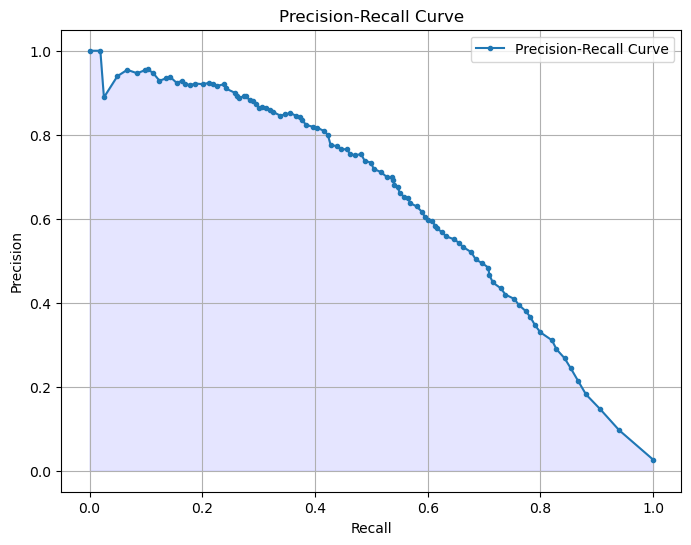

In [19]:
from sklearn.metrics import precision_recall_curve

# Train the RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_probs = clf.predict_proba(X_test)[:, 1]  # probabilities for class 1 (positive class)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.fill_between(recall, precision, alpha=0.1, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()